In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, fft

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

FTYPE = np.float32
ITYPE = np.int32


def invert_normalization(data, normalization_arr):
    new_data = np.empty_like(data)
    new_data[:] = data[:]
    new_data *= normalization_arr[1]
    new_data += normalization_arr[0]
    return new_data


def find_and_return_load_wt_file_lists(
        load_dir,
        wt_matcher='weights.hdf5',
        classdict_matcher='class_dict.txt',
    ):
    contents_load_dir = [f for f in os.listdir(load_dir) if os.path.isfile(os.path.join(load_dir, f))]
    load_files_lst = [f for f in contents_load_dir if f.endswith(classdict_matcher)]
    wt_files_lst = [f for f in contents_load_dir if f.endswith(wt_matcher)]

    load_files_lst_startingidx = []
    for i in range(len(load_files_lst)):
        fn = load_files_lst[i]
        idx = fn.find('_')
        load_files_lst_startingidx.append(int(fn[0:idx]))

    wt_files_lst_startingidx = []
    for i in range(len(wt_files_lst)):
        fn = wt_files_lst[i]
        idx = fn.find('_')
        wt_files_lst_startingidx.append(int(fn[0:idx]))

    load_files_sortidx = np.argsort(load_files_lst_startingidx)
    wt_files_sortidx = np.argsort(wt_files_lst_startingidx)

    load_files_lst = np.array(load_files_lst)[load_files_sortidx]
    wt_files_lst = np.array(wt_files_lst)[wt_files_sortidx]

    load_file_rnn = [load_dir + '/' + fn for fn in load_files_lst]
    wt_file_rnn = [load_dir + '/' +  fn for fn in wt_files_lst]
    
    return load_file_rnn, wt_file_rnn


def prediction_horizons(**kwargs):
    num_outsteps = kwargs['num_outsteps']
    dir_name_AR_AErnn = kwargs['dir_name_AR_AErnn']
    Autoencoder = kwargs['Autoencoder']
    # all_data = kwargs['all_data']
    data_rnn_input = kwargs['data_rnn_input']
    data_rnn_output = kwargs['data_rnn_output']
    AR_RNN = kwargs['AR_RNN']
    T_sample_input_rnn = kwargs['T_sample_input_rnn']
    T_sample_output_rnn = kwargs['T_sample_output_rnn']
    AR_AERNN = kwargs['AR_AERNN']
    normalization_constant_arr_rnn = kwargs['normalization_constant_arr_rnn']
    normalization_constant_arr_aedata = kwargs['normalization_constant_arr_aedata']
    time_stddev_ogdata = kwargs['time_stddev_ogdata']
    time_mean_ogdata = kwargs['time_mean_ogdata']
    batch_size = kwargs['batch_size']
    num_runs = kwargs.pop('num_runs', 100)
    error_threshold = kwargs.pop('error_threshold', 0.5)
    rnn_data_boundary_idx_arr = kwargs['rnn_data_boundary_idx_arr']
    lyapunov_time_arr = kwargs['lyapunov_time_arr']
    savefig_fname = kwargs['savefig_fname']
    data_to_consider = kwargs['data_to_consider']
    bin_width = kwargs.pop('bin_width', 0.05)
    bin_begin = kwargs.pop('bin_begin', 0.0)
    density = kwargs.pop('hist_pdf_flag', True)
    rnn_wt_extension = kwargs.pop('rnn_wt_extension', 'h5')
    ae_load_file = kwargs.pop('ae_load_file', None)
    ae_wt_file = kwargs.pop('ae_wt_file', None)
    rnn_load_file = kwargs.pop('rnn_load_file', None)
    rnn_wt_file = kwargs.pop('rnn_wt_file', None)
    use_ae_data = kwargs.pop('use_ae_data', True)
    xlabel_kwargs = kwargs.pop('xlabel_kwargs', {'fontsize':15})
    ylabel_kwargs = kwargs.pop('ylabel_kwargs', {'fontsize':15})
    title_kwargs = kwargs.pop('title_kwargs', {'fontsize':18})
    legend_kwargs = kwargs.pop('legend_kwargs', {'fontsize':12})
    
    if use_ae_data == True:
        ae_net = Autoencoder(data_rnn_input.shape[-1], load_file=ae_load_file)
        ae_net.load_weights_from_file(ae_wt_file)
    else:
        ae_net = None
        normalization_constant_arr_aedata = normalization_constant_arr_rnn
        normalization_constant_arr_rnn = None

    data_in_og = data_rnn_input
    data_out_og = data_rnn_output
    num_runs = np.min([num_runs, data_in_og.shape[0]])
    print('num_runs :', num_runs)

    rnn_net = AR_RNN(
        load_file=rnn_load_file,
        T_input=T_sample_input_rnn,
        T_output=T_sample_output_rnn,
        stddev=0.0,
        batch_size=num_runs,
        # stateful=stateful,
    )
        
    rnn_net.build(input_shape=(num_runs, data_rnn_input.shape[1], rnn_net.data_dim[0]))
    rnn_net.load_weights_from_file(rnn_wt_file)
    dt_rnn = rnn_net.dt_rnn
    try:
        dt_rnn = dt_rnn[0]
    except:
        pass
    
    AR_AERNN_net = AR_AERNN(
        ae_net,
        rnn_net,
        normalization_constant_arr_rnn,
        normalization_constant_arr_aedata,
        0.0,
        time_stddev_ogdata,
        time_mean_ogdata,
    )
    # AR_AERNN_net.build(input_shape=(batch_size,)+data_rnn_input.shape[1:])
    
    # data_idx_arr = np.arange(data_in_og.shape[0])
    # np.random.shuffle(data_idx_arr)
    data_idx_arr = np.linspace(0, data_in_og.shape[0]-1, num_runs, dtype=np.int32)

    prediction_horizon_arr = np.empty(shape=num_runs)
    pod_eigvals_dataout_arr = np.empty(shape=(num_runs, data_out_og.shape[-1]))
    pod_eigvals_pred_arr = np.empty(shape=(num_runs, data_out_og.shape[-1]))
    pod_covmat_dataout = np.zeros(shape=(data_out_og.shape[-1], data_out_og.shape[-1]))
    pod_covmat_pred = np.zeros(shape=(data_out_og.shape[-1], data_out_og.shape[-1]))

    prediction = AR_AERNN_net(data_in_og[data_idx_arr[0:num_runs], :, :], training=False).numpy()
    prediction = invert_normalization(prediction, normalization_constant_arr_aedata)

    energySpectrum_dataout = 0.0
    energySpectrum_pred = 0.0
    
    for i in range(num_runs):
        data_idx = data_idx_arr[i]

        for j in range(len(rnn_data_boundary_idx_arr)):
            if data_idx < rnn_data_boundary_idx_arr[j]:
                case_idx = j
                break
        lyap_time = lyapunov_time_arr[j]

        data_out = data_out_og[data_idx]
        data_out = invert_normalization(data_out, normalization_constant_arr_aedata)

        pod_dataout = data_out - np.mean(data_out, axis=0)
        pod_dataout = np.matmul(pod_dataout.transpose(), pod_dataout) / (pod_dataout.shape[0] - 1)
        pod_covmat_dataout += pod_dataout
        pod_dataout = np.abs(np.linalg.eigvals(pod_dataout))
        pod_dataout = np.sort(pod_dataout)
        pod_dataout = pod_dataout[::-1]
        pod_eigvals_dataout_arr[i, :] = pod_dataout
        
        pod_prediction = prediction[i, :, :] - np.mean(prediction[i, :, :], axis=0)
        pod_prediction = np.matmul(pod_prediction.transpose(), pod_prediction) / (pod_prediction.shape[0] - 1)
        pod_covmat_pred += pod_prediction
        pod_prediction = np.abs(np.linalg.eigvals(pod_prediction))
        pod_prediction = np.sort(pod_prediction)
        pod_prediction = pod_prediction[::-1]
        pod_eigvals_pred_arr[i, :] = pod_prediction

        ### Error and prediction horizon
        error = (data_out - prediction[i])**2
        error = np.mean(np.divide(error, time_stddev_ogdata**2), axis=1)**0.5

        predhor_idx = np.where(error >= error_threshold)[0]
        if predhor_idx.shape[0] == 0:
            predhor_idx = error.shape[0]
        else:
            predhor_idx = predhor_idx[0]

        prediction_horizon_arr[i] = predhor_idx*dt_rnn/lyap_time

    pod_eigvals_dataout_arr_mean = np.mean(pod_eigvals_dataout_arr, axis=0)
    pod_eigvals_pred_arr_mean = np.mean(pod_eigvals_pred_arr, axis=0)
    
    pod_covmat_dataout /= num_runs
    pod_covmat_pred /= num_runs

    median_idx = int(np.round(0.5*num_runs-1))
    quartile_1_idx = int(np.round(0.25*num_runs-1))
    quartile_3_idx = int(np.round(0.75*num_runs-1))

    prediction_horizon_arr.sort()

    median = prediction_horizon_arr[median_idx]
    quartile_1 = prediction_horizon_arr[quartile_1_idx]
    quartile_3 = prediction_horizon_arr[quartile_3_idx]
    IQR = quartile_3 - quartile_1

    prediction_horizon = np.mean(prediction_horizon_arr)
    stddev_ph = np.std(prediction_horizon_arr)

    ph_mean = np.mean(prediction_horizon_arr)
    ph_max = np.max(prediction_horizon_arr)
    ph_min = np.min(prediction_horizon_arr)
    ph_stddev = np.std(prediction_horizon_arr)
    
    s = 'error_threshold = {}, num_runs : {}\n'.format(error_threshold, num_runs)
    s += 'prediction_horizon : {}, median : {}\n'.format(prediction_horizon, median)
    s += 'ph_min : {}, ph_max : {}\n'.format(prediction_horizon_arr.min(), prediction_horizon_arr.max())
    s += 'stddev : {}, IQR : {}\n'.format(stddev_ph, IQR)
    s += '1st quartile : {}, 3rd quartile : {}'.format(quartile_1, quartile_3)

    print('\n'+s)
    
    if savefig_fname != None:
        npsavedata_fname = '/prediction_horizons-'+data_to_consider+'data--{}outsteps'.format(num_outsteps)
        np.savez(
            dir_name_AR_AErnn+npsavedata_fname,
            prediction_horizon_arr=prediction_horizon_arr,
            error_threshold=error_threshold,
        )

        with open(dir_name_AR_AErnn+npsavedata_fname+'--statistics.txt', 'w') as fl:
            fl.write(s)
        npsavepod_fname = '/pod_eigvals-'+data_to_consider+'data--{}outsteps'.format(num_outsteps)
        np.savez(
            dir_name_AR_AErnn+npsavepod_fname,
            pod_eigvals_dataout_arr=pod_eigvals_dataout_arr,
            pod_eigvals_pred_arr=pod_eigvals_pred_arr,
        )
    fig, ax = plt.subplots()

    bin_end = bin_width*np.round((np.max(prediction_horizon_arr)+0.5*bin_width)//bin_width)
    nbins = max(1, int(np.round(bin_end/bin_width)))

    ax.hist(prediction_horizon_arr, bins=nbins, range = [bin_begin, bin_end], density=density)
    ax.axvline(prediction_horizon, linewidth=0.9, linestyle='--', color='k')

    ax.set_xlabel('Prediction Horizon (Lyapunov times)', **xlabel_kwargs)
    ax.set_ylabel('PDF', **ylabel_kwargs)

    ax.grid(True)
    # ax.set_axisbelow(True)

    ax.text(
        0.01 + ax.transAxes.inverted().transform(ax.transData.transform([prediction_horizon, 0]))[0],
        0.8,
        'mean',
        rotation=90,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(facecolor=np.array([255,255,153])/255, alpha=0.6, boxstyle='square,pad=0.2'),
        transform=ax.transAxes
    )

    text_xy = [0.95, 0.95]
    ax.text(
        text_xy[0],
        text_xy[1],
        'mean : {:.4f}\nmedian : {:.4f}\nmax : {:.4f}\nmin : {:.4f}\nstddev : {:.4f}'.format(
            ph_mean,
            median,
            ph_max,
            ph_min,
            ph_stddev,
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
            alpha=0.6,
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='right',
        verticalalignment='top',
        **legend_kwargs
    )

    ax.set_title('nbins = {}'.format(nbins), **title_kwargs)

    if savefig_fname is not None:
        fig.savefig(
            dir_name_AR_AErnn+'/plots/'+savefig_fname+'--{}outsteps.pdf'.format(num_outsteps),
            dpi=300,
            bbox_inches='tight')
        fig.clear()
        plt.close()
    else:
        plt.show()
        print('')

    fig_eigvals, ax_eigvals = plt.subplots()
    ax_eigvals.semilogy(pod_eigvals_dataout_arr_mean, linestyle='--', marker='s', linewidth=0.9, markersize=2)
    ax_eigvals.semilogy(pod_eigvals_pred_arr_mean, linestyle='--', marker='^', linewidth=0.9, markersize=2)
    ax_eigvals.grid(True, which='both', axis='y')
    ax_eigvals.grid(True, which='major', axis='x')    
    ax_eigvals.legend([r'True Data', r'Predicted Data'], **legend_kwargs)
    ax_eigvals.set_axisbelow(True)
    ax_eigvals.set_title('Eigenvalues of the covariance matrix', **title_kwargs)
    if savefig_fname is not None:
        fig_eigvals.savefig(
            dir_name_AR_AErnn+'/plots/'+savefig_fname+'--eigvals--{}outsteps.pdf'.format(num_outsteps),
            dpi=300,
            bbox_inches='tight')
        fig_eigvals.clear()
        plt.close()
    else:
        plt.show()
        print('')

        

    fig_covmat = plt.figure(figsize=(5.0*3, 5.0*1))
    subplot1 = 1
    subplot2 = subplot1 + 1
    
    pod_covmat_dataout = np.divide(np.transpose(pod_covmat_dataout), np.diag(pod_covmat_dataout)).transpose()
    pod_covmat_pred = np.divide(np.transpose(pod_covmat_pred), np.diag(pod_covmat_dataout)).transpose()

    vmin_snap = 0.5
    vmax_snap = 0.5
    vmin = np.min([
        pod_covmat_dataout.min(),
        pod_covmat_pred.min()
    ])
    vmin = min(vmin, -1.0)
    vmin = -vmin_snap*np.round(-vmin/vmin_snap + 0.5)
    vmax = np.max([
        pod_covmat_dataout.max(),
        pod_covmat_pred.max()
    ])
    vmax = max(vmax, 1.0)
    vmax = vmax_snap*np.round(vmax/vmax_snap + 0.5)

    # plotting the original data
    ax_covmat_orig = fig_covmat.add_subplot(1, 3, subplot1)
    im_orig = ax_covmat_orig.imshow(
        pod_covmat_dataout,
        aspect='equal',
        origin='upper',
        vmin=vmin,
        vmax=vmax
    )
    ax_covmat_orig.set_title('Covariance Matrix (True Data)', **title_kwargs)
    # xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
    # ax_covmat_orig.set_xticks(ticks=xticks)
    # ax_covmat_orig.set_xticklabels(np.round(xticks*delta_t, 1))
    # ax_covmat_orig.tick_params(axis='x', rotation=270+45)
    # yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
    # yticklabels = np.round(xgrid[0]+np.linspace(0, 1, yticks.shape[0])*(xgrid[-1]-xgrid[0]), 2)
    # ax_covmat_orig.set_yticks(ticks=yticks)
    # ax_covmat_orig.set_yticklabels(yticklabels)
    # ax_covmat_orig.set_xlabel(xlabel)
    # ax_covmat_orig.set_ylabel(ylabel)

    # plotting the predicted data
    ax_covmat_predict = fig_covmat.add_subplot(1, 3, subplot2, sharey=ax_covmat_orig, sharex=ax_covmat_orig)
    im_predict = ax_covmat_predict.imshow(
        pod_covmat_pred,
        aspect='equal',
        origin='upper',
        vmin=vmin,
        vmax=vmax
    )
    ax_covmat_predict.set_title('Covariance Matrix (Predicted Data)', **title_kwargs)
    # ax_covmat_predict.tick_params(axis='x', rotation=270+45)
    # ax_covmat_predict.set_xlabel(xlabel)
    # ax_covmat_predict.set_ylabel(ylabel)

    # subplots adjustment to account for colorbars
    fig_covmat.subplots_adjust(
        bottom=0.2,
        left=0.1,
    )

    # original data and recon data colorbar
    cb_xbegin = ax_covmat_orig.transData.transform([0, 0])
    cb_xbegin = fig_covmat.transFigure.inverted().transform(cb_xbegin)[0]
    cb_xend = ax_covmat_predict.transData.transform([pod_covmat_dataout.shape[-1], 0])
    cb_xend = fig_covmat.transFigure.inverted().transform(cb_xend)[0]

    cb_ax = fig_covmat.add_axes([cb_xbegin, 0.0, cb_xend-cb_xbegin, 0.025])
    cbar = fig_covmat.colorbar(im_predict, cax=cb_ax, orientation='horizontal')

    # computing the normalized error
    subplot3 = subplot2+1
    error = np.abs(pod_covmat_pred-pod_covmat_dataout)
    vmax_error_snap = 0.8
    vmax_error = np.max(error)
    vmax_error = vmax_error_snap*np.round(vmax_error/vmax_error_snap + 0.5)
    # error = 100*error / np.abs(pod_covmat_dataout)
    # plotting the normalized error
    ax_covmat_error = fig_covmat.add_subplot(1, 3, subplot3, sharey=ax_covmat_orig, sharex=ax_covmat_orig)
    im_error = ax_covmat_error.imshow(
        error,
        aspect='equal',
        origin='upper',
        vmin=0.0,
        vmax=vmax_error,
    )
    ax_covmat_error.set_title(r'Error', **title_kwargs)
    # ax_error.tick_params(axis='x', rotation=270+45)
    # ax_error.set_xlabel(xlabel)
    # ax_error.set_ylabel(ylabel)

    # error colorbar
    cbe_xbegin = ax_covmat_error.transData.transform([0, 0])
    cbe_xbegin = fig_covmat.transFigure.inverted().transform(cbe_xbegin)[0]
    cbe_xend = ax_covmat_error.transData.transform([pod_covmat_dataout.shape[-1], 0])
    cbe_xend = fig_covmat.transFigure.inverted().transform(cbe_xend)[0]
    error_cb_ax = fig_covmat.add_axes([cbe_xbegin, 0.0, cbe_xend-cbe_xbegin, 0.025])
    cbar_error = fig_covmat.colorbar(im_error, cax=error_cb_ax, orientation='horizontal')
    
    if savefig_fname is not None:
        fig_covmat.savefig(
            dir_name_AR_AErnn+'/plots/'+savefig_fname+'--covmat--{}outsteps.pdf'.format(num_outsteps),
            dpi=300,
            bbox_inches='tight')
        fig_covmat.clear()
        plt.close()
    else:
        plt.show()
        print('')
    
    return prediction


from numpy import *
def main(esn_dir_idx, gpu_to_use):
    strategy = None

    current_sys = platform.system()
    if current_sys == 'Windows':
        dir_sep = '\\'
    else:
        dir_sep = '/'

    print(os.getcwd())

    from tools.misc_tools import create_data_for_RNN, readAndReturnLossHistories
    from tools.ae_v2 import Autoencoder
    from tools.ESN_v1_ensembleAR import ESN_ensemble as AR_RNN
    from tools.AEESN_AR_v1 import AR_AERNN_ESN as AR_AERNN

    gpus = tf.config.list_physical_devices('GPU')
    print(gpus)

    if strategy is None:
        if gpus:
            # gpu_to_use = 0
            # tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
            tf.config.set_visible_devices([], 'GPU') # no gpu used
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

    print(tf.config.list_physical_devices())
    print('')
    print(tf.config.list_logical_devices())
    print('')
    print(tf.__version__)


    ###--- CDV System ---###
    ### setting up params (and saving, if applicable)

    ### AR AE-RNN directory
    esn_dir_idx = '{:3d}'.format(esn_dir_idx)
    esn_dir_idx = esn_dir_idx.replace(' ', '0')
    dir_name_AR_AErnn = os.getcwd()+'/saved_AR_AEESN_rnn/AR_ESN_ensemble_' + esn_dir_idx

    ### reading AR-RNN parameters
    with open(dir_name_AR_AErnn + '/AR_RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_AR_AErnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_AErnn_dict['dir_name_rnn']
    idx1 = dir_name_rnn[::-1].find('/')
    idx2 = dir_name_rnn[:-idx1-1][::-1].find('/')
    dir_name_rnn = os.getcwd() + dir_name_rnn[-idx1-idx2-1-1:]

    dir_name_ae = params_AR_AErnn_dict['dir_name_ae']
    ae_idx = dir_name_ae[-3:]
    dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

    dt_rnn = params_AR_AErnn_dict['dt_rnn']
    # T_sample_input = params_AR_AErnn_dict['T_sample_input']
    T_sample_output = params_AR_AErnn_dict['T_sample_output']
    if type(T_sample_output) != type(np.array([])):
        if type(T_sample_output) != type([]):
            T_sample_output = [T_sample_output]
        T_sample_output = np.array(T_sample_output)
    num_outsteps = np.int32(np.round(T_sample_output/dt_rnn))
    # T_offset = params_AR_AErnn_dict['T_offset']
    return_params_arr = params_AR_AErnn_dict['return_params_arr']
    params = params_AR_AErnn_dict['params']
    try:
        # this is the normalization flag for the data fed into the rnn
        normalize_dataset = params_AR_AErnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        use_ae_data = params_AR_AErnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in AR_rnn_specific_data, set to True.")
        use_ae_data = True

    ### reading RNN normalization constants
    normalization_arr_rnn = None
    # if normalize_dataset == True:
    #     with open(dir_name_AR_AErnn + '/final_net/rnn_normalization.txt') as f:
    #         lines = f.readlines()
    #     normarr_rnn_dict = eval(''.join(lines))
    #     normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

    if os.path.exists(dir_name_AR_AErnn+'/normalization_data.npz'):
        with np.load(dir_name_AR_AErnn+'/normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr_rnn = fl['normalization_arr'][0]

    ### training params
    with open(dir_name_AR_AErnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    ### reading simulation parameters
    with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
        lines = f.readlines()
    params_dict = eval(''.join(lines))
    data_dir_idx = params_dict['data_dir_idx']
    normalizeforae_flag = params_dict['normalizeforae_flag']
    normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
    try:
        ae_data_with_params = params_dict['ae_data_with_params']
    except:
        print("'ae_data_with_params' not present in ae_data, set to 'True'.")
        ae_data_with_params = True

    print('dir_name_AR_AErnn:', dir_name_AR_AErnn)
    print('dir_name_rnn:', dir_name_rnn)
    print('dir_name_ae:', dir_name_ae)
    print('data_dir_idx:', data_dir_idx)

    ### loading data
    dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
        
    with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
        lines = f.readlines()
    params_dict = eval(''.join(lines))
    params_mat = params_dict['params_mat']
    # init_state = params_dict['init_state']
    t0 = params_dict['t0']
    T = params_dict['T']
    delta_t = params_dict['delta_t']
    return_params_arr = params_dict['return_params_arr']
    normalize_flag_ogdata = params_dict['normalize_flag']
    print('normalize_flag_ogdata:', normalize_flag_ogdata)
    alldata_withparams_flag = params_dict['alldata_withparams_flag']

    with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
        all_data = fl['all_data'].astype(FTYPE)
        boundary_idx_arr = fl['boundary_idx_arr']
        normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
        initial_t0 = fl['initial_t0']
        init_state_mat = fl['init_state_mat']

        lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

    # set which data to use for plotting histogram
    data_to_consider = 'training' # could be 'all', 'testing', 'training', 'val'

    lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
    for i in range(lyapunov_spectrum_mat.shape[0]):
        lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
        print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

    # delaing with normalizing the data before feeding into autoencoder
    num_params = params_mat.shape[1]
    og_vars = all_data.shape[1]
    if alldata_withparams_flag == True:
        og_vars -= num_params

    if use_ae_data == True and ae_data_with_params == False:
        all_data = all_data[:, 0:og_vars]
    else:
        all_data = all_data[:, 0:og_vars]
        
    normalization_constant_arr_aedata = normalization_constant_arr_aedata[:, 0:all_data.shape[1]]

    print('all_data.shape : ', all_data.shape)
    print('all_data.dtype : ', all_data.dtype)

    ###--- Create Data ---###
    T_sample_input_cd_AR = 1
    T_sample_output_cd_AR = 10
    T_sample_input_cd = T_sample_input_cd_AR*np.mean(lyapunov_time_arr)#50.1*dt_rnn
    T_sample_output_cd = T_sample_output_cd_AR*np.mean(lyapunov_time_arr)
    T_offset_cd = T_sample_input_cd

    skip_intermediate_cd = T_sample_input_cd_AR/(T_sample_input_cd_AR+T_sample_output_cd_AR)

    time_mean_ogdata = np.mean(all_data, axis=0)
    time_stddev_ogdata = np.std(all_data, axis=0)

    rnn_res_dict = create_data_for_RNN(
        all_data,
        dt_rnn,
        T_sample_input_cd,
        T_sample_output_cd,
        T_offset_cd,
        None,
        boundary_idx_arr,
        delta_t,
        params=params,
        return_numsamples=True,
        normalize_dataset=normalizeforae_flag,
        stddev_multiplier=3.0,
        skip_intermediate=skip_intermediate_cd,
        return_OrgDataIdxArr=False,
        normalization_arr_external=normalization_constant_arr_aedata,
        normalization_type='stddev')

    data_rnn_input = rnn_res_dict['data_rnn_input']
    data_rnn_output = rnn_res_dict['data_rnn_output']
    org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
    org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
    num_samples = rnn_res_dict['num_samples']
    normalization_arr = rnn_res_dict['normalization_arr']
    rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

    temp = np.divide(all_data-normalization_arr[0], normalization_arr[1])
    time_stddev = np.std(temp, axis=0)
    timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
    del(org_data_idx_arr_input)
    del(org_data_idx_arr_output)
    del(temp)

    if data_to_consider != 'all':
        cum_samples = rnn_data_boundary_idx_arr[-1]
        num_train = 0
        num_val = 0
        begin_idx = 0
        for i in range(len(boundary_idx_arr)):
            num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
            num_train += int( np.round(train_split*num_samples) )
            num_val += int( np.round(val_split*num_samples) )
            begin_idx = rnn_data_boundary_idx_arr[i]

        # defining shapes
        training_input_shape = [num_train]
        training_input_shape.extend(data_rnn_input.shape[1:])

        training_output_shape = [num_train]
        training_output_shape.extend(data_rnn_output.shape[1:])

        val_input_shape = [num_val]
        val_input_shape.extend(data_rnn_input.shape[1:])

        val_output_shape = [num_train]
        val_output_shape.extend(data_rnn_output.shape[1:])

        testing_input_shape = [cum_samples-num_train-num_val]
        testing_input_shape.extend(data_rnn_input.shape[1:])

        testing_output_shape = [cum_samples-num_train-num_val]
        testing_output_shape.extend(data_rnn_output.shape[1:])

        shape_to_use = eval(data_to_consider+'_input_shape')
        rnn_data_idx = np.empty(shape=shape_to_use[0], dtype=np.int32)
        
        begin_idx = 0
        training_data_rolling_count = 0
        val_data_rolling_count = 0
        testing_data_rolling_count = 0
        for i in range(len(boundary_idx_arr)):
            num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
            num_train = int( np.round(train_split*num_samples) )
            num_val = int( np.round(val_split*num_samples) )
            num_test = num_samples-num_train-num_val+1

            if data_to_consider == 'training':
                rnn_data_idx[training_data_rolling_count:training_data_rolling_count+num_train] = np.arange(begin_idx, begin_idx+num_train)
            elif data_to_consider == 'val':
                rnn_data_idx[val_data_rolling_count:val_data_rolling_count+num_val] = np.arange(begin_idx+num_train, begin_idx+num_train+num_val)
            elif data_to_consider == 'testing':
                rnn_data_idx[testing_data_rolling_count:testing_data_rolling_count+num_test] = np.arange(begin_idx+num_train+num_val, rnn_data_boundary_idx_arr[i])

            training_data_rolling_count += num_train
            val_data_rolling_count += num_val
            testing_data_rolling_count += num_test

            begin_idx = rnn_data_boundary_idx_arr[i]

        # shuffling
        np.random.shuffle(rnn_data_idx)
        data_rnn_input = data_rnn_input[rnn_data_idx]
        data_rnn_output = data_rnn_output[rnn_data_idx]
        del(rnn_data_idx)

    print(' data_rnn_input.shape :', data_rnn_input.shape)
    print('data_rnn_output.shape :', data_rnn_output.shape)

    ###--- Prediction Horizon ---###

    num_runs = 100
    num_runs = min(num_runs, data_rnn_input.shape[0])

    
    return_lst = [
        [
            dir_name_AR_AErnn, data_rnn_input, data_rnn_output,
            normalization_constant_arr_aedata, time_stddev_ogdata,
            num_outsteps, lyapunov_time_arr, dt_rnn
        ]
    ]
    for kk in range(num_outsteps.shape[0]+1):    
        total_s_len = 80
        
        if kk == 0:
            num_outsteps_kk = 'ZERO'
            load_dir = dir_name_rnn + '/final_net/'
            load_file_rnn, wt_file_rnn = find_and_return_load_wt_file_lists(load_dir)

            load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
            wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'
        else:
            num_outsteps_kk = num_outsteps[kk-1]
            
            load_dir = dir_name_AR_AErnn + '/final_net/{}_outsteps'.format(num_outsteps_kk)
            load_file_rnn, wt_file_rnn = find_and_return_load_wt_file_lists(
                load_dir,
                wt_matcher='ESN_weights.hdf5',
                classdict_matcher='ESN_class_dict.txt',
            )

            load_file_ae = dir_name_AR_AErnn+'/final_net/{}_outsteps/final_net-{}_outsteps_ae_class_dict.txt'.format(
                num_outsteps_kk, num_outsteps_kk)
            wt_file_ae = dir_name_AR_AErnn+'/final_net/{}_outsteps/final_net-{}_outsteps_ae_weights.h5'.format(
                num_outsteps_kk, num_outsteps_kk)    
        
        sep_lr_s = ' num_outsteps : {} '.format(num_outsteps_kk)
        
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
        print('\n\n' + '*'*len(sep_lr_s))
        print('' + sep_lr_s+'')
        print('*'*len(sep_lr_s) + '\n\n')

        preds = prediction_horizons(
            num_outsteps=num_outsteps_kk,
            dir_name_AR_AErnn=dir_name_AR_AErnn,
            Autoencoder=Autoencoder,
            data_rnn_input=data_rnn_input,
            data_rnn_output=data_rnn_output,
            AR_RNN=AR_RNN,
            T_sample_input_rnn=T_sample_input_cd,
            T_sample_output_rnn=T_sample_output_cd,
            AR_AERNN=AR_AERNN,
            normalization_constant_arr_rnn=normalization_arr_rnn,
            normalization_constant_arr_aedata=normalization_constant_arr_aedata,
            time_stddev_ogdata=time_stddev_ogdata,
            time_mean_ogdata=time_mean_ogdata,
            batch_size=num_runs,
            num_runs=num_runs,
            error_threshold=0.5,
            rnn_data_boundary_idx_arr=rnn_data_boundary_idx_arr,
            lyapunov_time_arr=lyapunov_time_arr,
            savefig_fname='post-ARtraining'+'_'+data_to_consider+'data--combinedAERNN',
            data_to_consider=data_to_consider,
            bin_width=0.05,
            bin_begin=0.0,
            rnn_wt_extension='hdf5', # 'h5' for tf saved rnns, 'hdf5' for my ESNs
            rnn_load_file=load_file_rnn,
            rnn_wt_file=wt_file_rnn,
            ae_load_file=load_file_ae,
            ae_wt_file=wt_file_ae,
            use_ae_data=use_ae_data,
        )
        
        return_lst.append(preds)
    
    return return_lst
        

# if __name__ == '__main__':
#     import argparse
#     parser = argparse.ArgumentParser()
#     parser.add_argument('gpu_to_use', type=int)
#     parser.add_argument('esn_dir_idx', type=int)
    
#     args = parser.parse_args()
    
#     print('gpu_to_use : {}, esn_dir_idx : {}'.format(args.gpu_to_use, args.esn_dir_idx))
    
#     main(args.esn_dir_idx, args.gpu_to_use)

In [2]:
xlabel_kwargs={"fontsize":15}
ylabel_kwargs={"fontsize":15}
title_kwargs={"fontsize":17}
legend_kwargs={"fontsize":12}

In [3]:
main_tuple = main(5, 0)

/home/rkaushik/Documents/Thesis/MLROM/new_lorenz
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]

2.8.1
dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AEESN_rnn/AR_ESN_ensemble_005
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ESN_ensemble/ESN_ensemble_002
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae/ae_024
data_dir_idx: 010
normalize_flag_ogdata: False


2023-08-10 00:46:40.951998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-10 00:46:41.002240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-10 00:46:41.002512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-10 00:46:41.003440: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Case : 1, lyapunov exponent : 0.9058021372262592, lyapunov time : 1.1039938926696777s
all_data.shape :  (4200001, 3)
all_data.dtype :  float32
 data_rnn_input.shape : (30537, 11, 3)
data_rnn_output.shape : (30537, 110, 3)


********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : ZERO <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


num_runs : 100

error_threshold = 0.5, num_runs : 100
prediction_horizon : 2.4157742336333596, median : 2.3550854921060123
ph_min : 0.3623208449393865, ph_max : 5.706553307795338
stddev : 0.9478564508019648, IQR : 1.0869625348181597
1st quartile : 1.9021844359317792, 3rd quartile : 2.989146970749939


********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 5 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
******************************************************************

In [4]:
len(main_tuple), len(main_tuple[0])

(6, 8)

d_idx : 43
4.2572699280377915


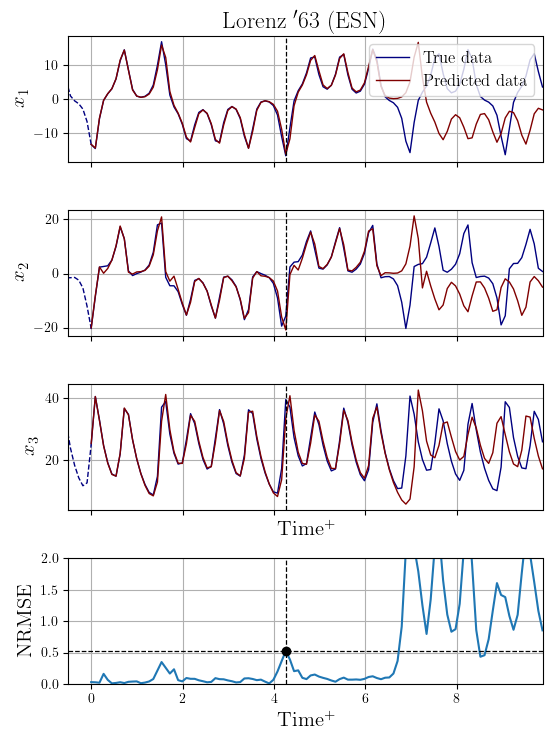

d_idx : 43
3.442048026924172


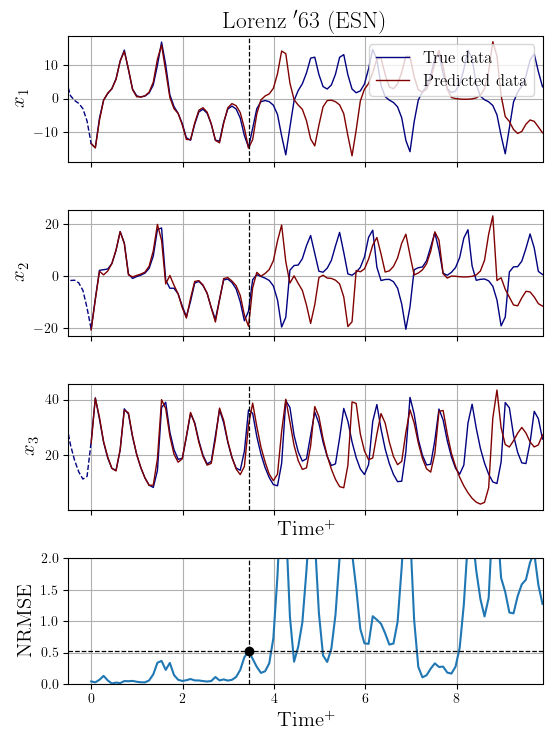

d_idx : 43
1.5398635909923928


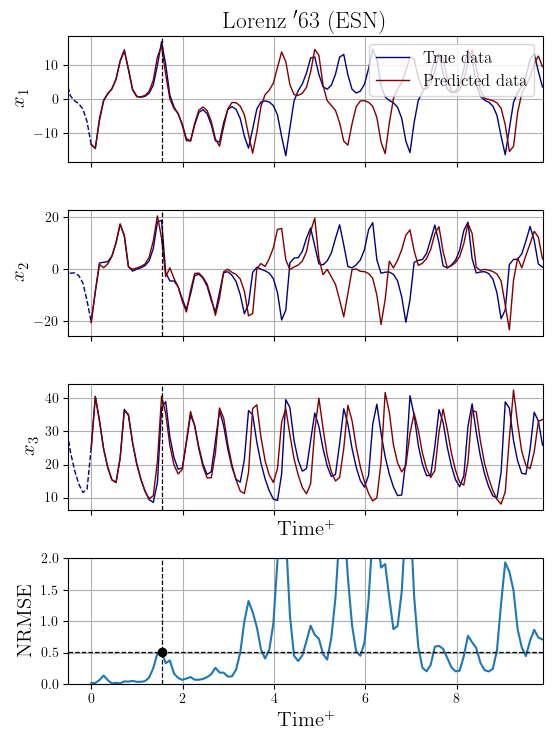

d_idx : 43
3.3514678156893254


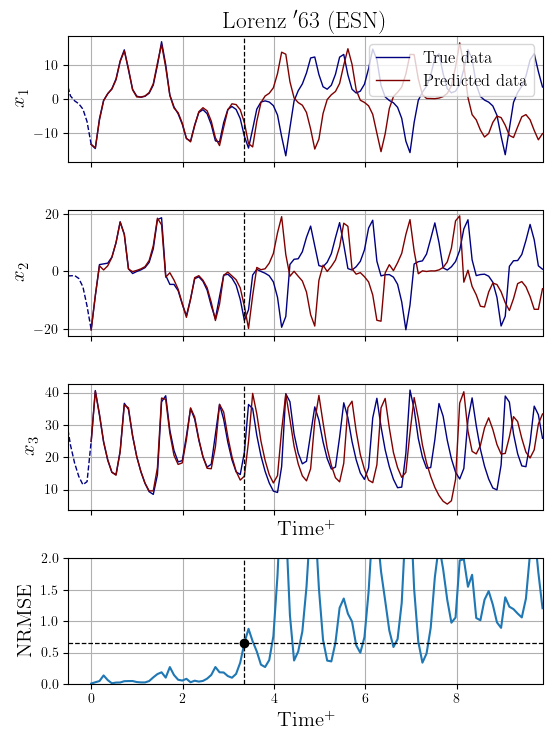

d_idx : 43
3.3514678156893254


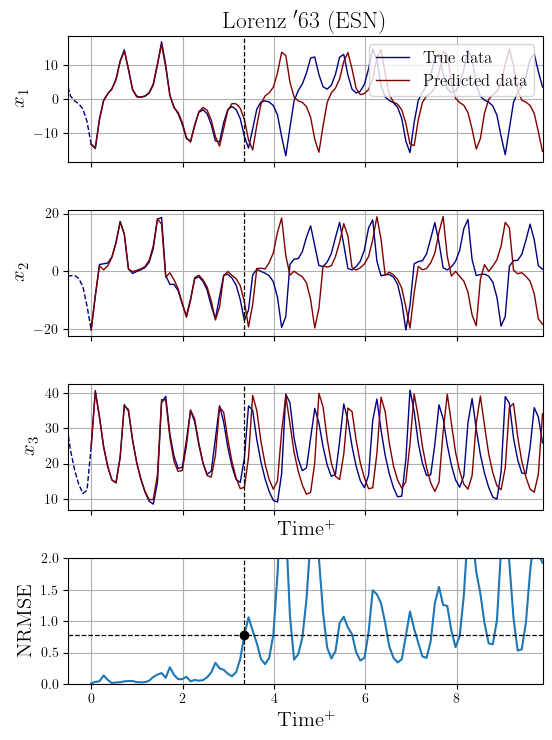

In [5]:
dir_name_AR_AErnn = main_tuple[0][0]
data_rnn_input = main_tuple[0][1]
data_rnn_output = main_tuple[0][2]
normalization_constant_arr_aedata = main_tuple[0][3]
time_stddev_ogdata = main_tuple[0][4]
num_outsteps = main_tuple[0][5]
lyapunov_time_arr = main_tuple[0][6]
dt_rnn = main_tuple[0][7]

lyap_time = np.mean(lyapunov_time_arr)
data_idx_arr = np.linspace(0, data_rnn_input.shape[0]-1, main_tuple[1].shape[0], dtype=np.int32)
AR_testing_data_rnn_input = data_rnn_input[data_idx_arr]
AR_testing_data_rnn_output = data_rnn_output[data_idx_arr]

d_idx = np.random.randint(low=0, high=AR_testing_data_rnn_input.shape[0])

for i_mt in range(1, len(main_tuple)):
    prediction = main_tuple[i_mt]
    # d_idx = np.random.randint(low=0, high=AR_testing_data_rnn_input.shape[0])
    # d_idx = 7 # 1, 7, 11, 86, 99
    print('d_idx : {}'.format(d_idx))

    num_sample_input_AR = prediction.shape[-2]
    num_sample_input_AR = AR_testing_data_rnn_input.shape[-2]

    n = 1
    num_latent_states = prediction.shape[-1]
    N = prediction.shape[-2]#num_output_timesteps

    num_cols = 1
    num_rows = n*num_latent_states+1

    ax_ylabels = [r'$x_{'+str(i+1)+'}$' for i in range(num_latent_states)]

    fig, ax = plt.subplots(num_latent_states+1, 1, sharex=True, figsize=np.array([7.5*num_cols, 2.5*num_rows])*0.75)
    if num_latent_states == 1:
        ax = [ax]

    cmap = plt.get_cmap('jet')
    colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

    prev_idx = 0

    time_arr_warmup1 = (np.arange(num_sample_input_AR+1) - num_sample_input_AR)*dt_rnn
    # time_arr_warmup2 = time_arr_warmup1 + dt_rnn

    time_arr_warmup1 /= lyap_time
    # time_arr_warmup2 /= lyap_time

    input_time = time_arr_warmup1[-1]+np.arange(N, dtype=float)*dt_rnn/lyap_time

    din_shape = np.array(AR_testing_data_rnn_input[d_idx].shape)
    din_shape[0] += 1
    data_in_plot = np.empty(shape=din_shape)
    data_in_plot[:-1] = AR_testing_data_rnn_input[d_idx]
    data_in_plot[-1] = AR_testing_data_rnn_output[d_idx, 0]
    data_out_plot = np.empty_like(AR_testing_data_rnn_output[d_idx])
    data_out_plot[:] = AR_testing_data_rnn_output[d_idx]

    data_in_plot = invert_normalization(data_in_plot, normalization_constant_arr_aedata)
    data_out_plot = invert_normalization(data_out_plot, normalization_constant_arr_aedata)


    for j in range(num_latent_states):
        for i in range(n):
            ax[j].plot(time_arr_warmup1, data_in_plot[:, j], linestyle='--', linewidth=1, color=colors[2*i], label='__nolabel__')#'actual warmup data')#.format(i+1))
            # ax[j].plot(time_arr_warmup2, input_preds[:, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
            ax[j].plot(input_time, data_out_plot[:, j], linewidth=1, color=colors[2*i], label='True data')# .format(i+1))
            ax[j].plot(input_time, prediction[d_idx, :, j], linewidth=1, color=colors[2*i+1], label='Predicted data')#.format(i+1))
        ax[j].set_ylabel(ax_ylabels[j], **ylabel_kwargs)
        ax[j].grid(True)
        ax[j].set_axisbelow(True)
        # ax[j].set_ylim([-1, 1])
        ax[j].set_xlim([input_time[0] - 0.5, input_time[-1]])


    ax[-2].set_xlabel('Time$^+$', **xlabel_kwargs)

    max_rows = 10
    max_rows = float(max_rows)
    # ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
    ncols = int(np.ceil(1 / max_rows))
    ax[0].legend(
        loc=1,
        ncol=ncols,
        **legend_kwargs,
    )
    ax[0].set_title(r"Lorenz $'63$ (ESN)", **title_kwargs)


    ### error computation
    error = (data_out_plot - prediction[d_idx])**2
    # error /= norm_sq_time_average(data_out)**0.5
    error = np.mean(np.divide(error, time_stddev_ogdata**2), axis=1)**0.5

    # print(norm_sq_time_average(data_out)**0.5)

    # fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
    ax2 = ax[-1]
    ax2.plot(input_time, error)
    ax2.grid(True)
    ax2.set_axisbelow(True)
    ax2.set_xlabel('Time$^+$', **xlabel_kwargs)
    ax2.set_ylabel('NRMSE', **ylabel_kwargs)

    error_threshold = 0.5

    predhor_idx = np.where(error >= error_threshold)[0]
    if len(predhor_idx.shape) == 0 or predhor_idx.shape[0] == 0:
        predhor_idx = error.shape[0]-1
    else:
        predhor_idx = np.sort(predhor_idx)[0]
    ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
    ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
    # ax2.plot(input_time[predhor_idx], error_threshold, 'o', color='k')
    # ax2.axhline(error_threshold, linewidth=0.9, linestyle='--', color='k')

    for i in range(len(ax)):
        ax[i].axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')
    ax2.set_ylim([0, 2])

    prediction_horizon = predhor_idx*dt_rnn/lyap_time
    print(prediction_horizon)

    plt.tight_layout()

    plot_idx = '{:04d}'.format(num_outsteps[i_mt-2]) if i_mt >= 2 else 'ZERO'
    plt.savefig(dir_name_AR_AErnn+'/plots/time_prediction--{}outsteps.pdf'.format(plot_idx), dpi=300, bbox_inches='tight')

    plt.show()
    plt.close()

    np.savez(
        dir_name_AR_AErnn+'/plots/time_prediction--{}outsteps'.format(plot_idx),
        data_in_plot=data_in_plot,
        data_out_plot=data_out_plot,
        prediction=prediction[d_idx],
        error=error,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        dt_rnn=dt_rnn,
        lyapunov_time_arr=lyapunov_time_arr,
        num_outsteps=[plot_idx],
    )